In [26]:
import os as os
import warnings

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable

import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt

from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import odeint
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy import integrate

In [27]:
# Generate data
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

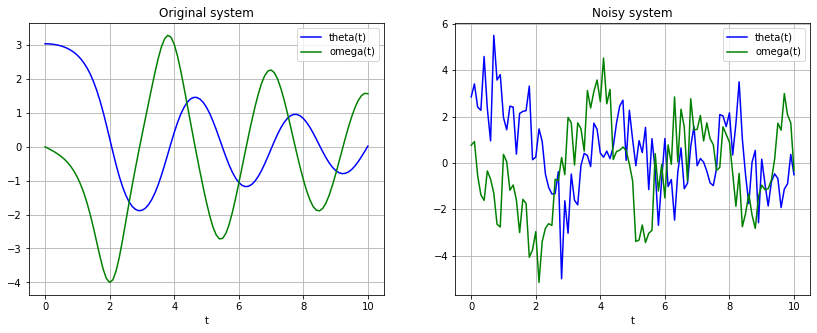

y.shape= (101, 2)


In [28]:
def pend(y, t, b, c):
  # Example from https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
  theta, omega = y
  dydt = [omega, -b*omega - c*np.sin(theta)]
  return dydt

# Define parameters
b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 101)

# Solve system
y = odeint(pend, y0, t, args=(b, c))

f,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t, y[:, 0], 'b', label='theta(t)')
ax[0].plot(t, y[:, 1], 'g', label='omega(t)')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_title('Original system')
ax[0].grid()

# Add noise
sigma = 1
y += np.random.normal(0, sigma ** 2, y.shape)

ax[1].plot(t, y[:, 0], 'b', label='theta(t)')
ax[1].plot(t, y[:, 1], 'g', label='omega(t)')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_title('Noisy system')
ax[1].grid()

plt.show()
print("y.shape=",y.shape)

In [29]:
# Thinning the data set
t_coarse = t[::2]
y_coarse = y[::2]

Define models

In [30]:
with pm.Model() as fine_model:
  # Define priors
  intercept = pm.Normal("intercept", 0, sigma=20)
  slope = pm.Normal("slope", 0, sigma=20)

  # Define likelihood
  likelihood = pm.Normal("y", mu=intercept + slope * t, sigma=sigma, observed=y[:,0])

In [31]:
# Constructing the coarse model
with pm.Model() as coarse_model:
  # Define priors
  intercept = pm.Normal("intercept", 0, sigma=20)
  slope = pm.Normal("slope", 0, sigma=20)

  # Define likelihood
  likelihood = pm.Normal("y", mu=intercept + slope * t_coarse, sigma=sigma, observed=y_coarse[:,0])

In [32]:
with fine_model:
    # Initialise step methods
    step = pm.MLDA(coarse_models=[coarse_model], subsampling_rates=[10])
    
    # Sample using MLDA
    t_start = time.time()
    trace = pm.sample(draws=6000, chains=4, tune=2000, step=step, random_seed=RANDOM_SEED)
    runtime = time.time() - t_start

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Sequential sampling (4 chains in 1 job)
MLDA: [slope, intercept]


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b982e7850>,
      dtype=object)

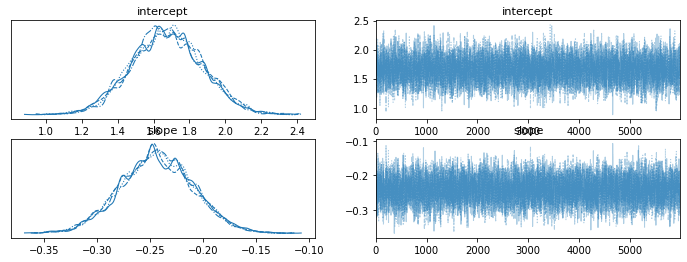

In [33]:
# Trace plots
az.plot_trace(trace)

In [34]:
# Summary statistics for MLDA
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.676,0.199,1.294,2.037,0.002,0.002,7656.0,7115.0,1.0
slope,-0.244,0.034,-0.307,-0.178,0.000,0.000,8314.0,8186.0,1.0


In [40]:
# Try the simple model
mu = trace['intercept'].mean()
slope = trace['slope'].mean()

In [42]:
y_hat = mu*t+slope

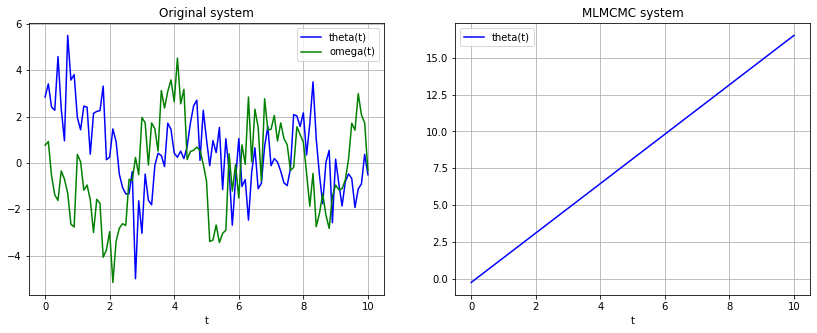

In [44]:
f,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t, y[:, 0], 'b', label='theta(t)')
ax[0].plot(t, y[:, 1], 'g', label='omega(t)')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_title('Original system')
ax[0].grid()

ax[1].plot(t, y_hat, 'b', label='theta(t)')
# ax[1].plot(t, y_hat, 'g', label='omega(t)')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_title('MLMCMC system')
ax[1].grid()